## Multi_Agent supervisor

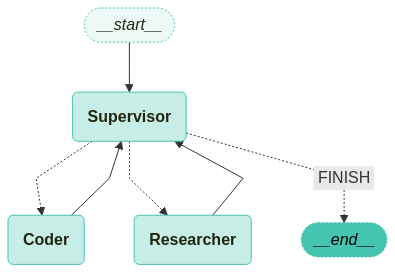

Set up the environment. 

In [1]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

## Setting State

Define **state** to be used in the multi-agent system.

In [2]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict


class AgentState(TypedDict):
    """Define state to be used in the multi-agent system."""
    messages: Annotated[Sequence[BaseMessage], operator.add]  # messages
    next: str  # next agent to route to

## Creating Agents

### Creating Tools

In this example, we'll create agents that use a search engine to perform web research and generate plots.

Define the tools to be used below.

- **Research** : Use `TavilySearch` tool to perform web research. To use this tool, you need to set the `TAVILY_API_KEY` . Please refer to [previous tutorial](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/15-agent/01-tools#search-api-tooltavily) for more details.
- **Coder** : Use `PythonREPLTool` tool to run code.

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool


# Initialize Tavily search tool that returns up to 5 search results
tavily_tool = TavilySearchResults(max_results=5)

# Initialize Python REPL tool that runs code locally (may not be safe)
python_repl_tool = PythonREPLTool()

### Creating Utility for Creating Agents

When building a multi-agent system using LangGraph, **helper functions** play a crucial role in creating and managing agent nodes. These functions enhance code reusability and simplify interactions between agents.

- **Creating Agent Nodes** : Define functions to create nodes for each agent's role
- **Managing Workflow** : Provide utilities to manage the workflow between agents
- **Error Handling** : Include mechanisms to handle errors that may occur during agent execution

The following is an example of defining a function called `agent_node` .

This function creates an agent node using the given state and agent. We will call this function later using `functools.partial` .

In [4]:
from langchain_core.messages import HumanMessage


# Create an agent node using the specified agent and name
def agent_node(state, agent, name):
    # Call the agent
    agent_response = agent.invoke(state)
    # Convert the last message of the agent to a HumanMessage and return it
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

Below is an example of creating a `research_node` using `functools.partial` .

In [5]:
import functools

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# Create a Research Agent
research_agent = create_react_agent(AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
), tools=[tavily_tool])

# Create a Research Node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

Let's run the code and check the results.

In [6]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

{'messages': [HumanMessage(content='Here\'s a simple code snippet to print "Hello World!" to the terminal in Python:\n\n```python\nprint("Hello World!")\n```\n\n### Steps to run this code:\n1. Open a terminal or command-line interface.\n2. Create a file named `hello_world.py` using a text editor.\n3. Copy the code above into the file and save it.\n4. In the terminal, navigate to the directory where the file is located.\n5. Run the file using the command:\n   ```bash\n   python hello_world.py\n   ``` \n\nThis will print "Hello World!" to the terminal. Let me know if you\'d like a similar example in another programming language!', additional_kwargs={}, response_metadata={}, name='Researcher')]}

### Creating Agent Supervisor

Create an agent that manages and supervises agents.

In [7]:
from typing import Literal

from pydantic import BaseModel


# Define the list of member agents
members = ["Researcher", "Coder"]

# Define the list of options for selecting the next worker
options_for_next = ["FINISH"] + members

# Define the response model for selecting the next worker: indicates selecting the next worker or completing the task
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import AzureChatOpenAI


# Define the system prompt: a supervisor tasked with managing a conversation between workers
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Create ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))

# Initialize LLM
llm = AzureChatOpenAI(model="gpt-4o")

# Create Supervisor Agent
def supervisor_agent(state):
    # Combine prompt and LLM to create a chain
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Call the agent
    return supervisor_chain.invoke(state)

## Constructing the Graph

Now, we're ready to build the graph. Below, we'll use the functions we just defined to define `state` and `worker` nodes.

In [9]:
import functools

from langgraph.prebuilt import create_react_agent


# Create Research Agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### Font Settings #####
import matplotlib.pyplot as plt

# Set universal font settings
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False  # Prevent minus sign from breaking

# Set English locale
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
"""

# Create Coder Agent
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph


# Create graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)

# Add edges from member nodes to the Supervisor node
for member in members:
    workflow.add_edge(member, "Supervisor")

# Add conditional edges
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

def get_next(state):
    return state["next"]

# Add conditional edges from the Supervisor node
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# Add starting point
workflow.add_edge(START, "Supervisor")

# Compile the graph
graph = workflow.compile(checkpointer=MemorySaver())

Visualize the graph.

In [ ]:
#%pip install langchain_opentutorial

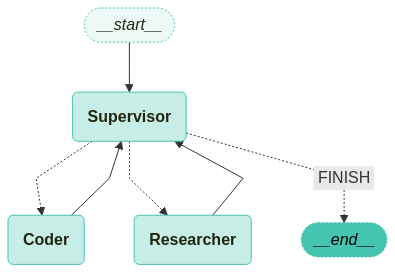

In [11]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

## Calling the Team

Now, we can check the performance by calling the graph.

In [ ]:
#%pip install matplotlib


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_GTCVQEADsDL2wwnC2bl3H2Tq)
 Call ID: call_GTCVQEADsDL2wwnC2bl3H2Tq
  Args:
    query: GDP per capita of South Korea from 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "South Korea GDP - Worldometer", "url": "https://www.worldometers.info/gdp/south-korea-gdp/", "content": "GDP per Capita in the Republic of Korea (with a population of 51,748,739 people) was $34,097 in 2023, an increase of $478 from $33,619 in 2022; this represents", "score": 0.8655088}, {"title": "South Korea GDP per Capita | Economic Indicators - CEIC

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_SL9MUSCbK7oIERGb8uoxawr1)
 Call ID: call_SL9MUSCbK7oIERGb8uoxawr1
  Args:
    query: import matplotlib.pyplot as plt

# Set universal font settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # Prevent minus sign from breaking

# Data
years = list(range(2010, 2025))
gdp_per_capita = [23077, 25100, 25459, 27179, 29253, 28737, 29900, 31800, 32700, 33700, 33300, 37503, 34809, 35570, 47509]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o', label='GDP per capita (USD)')
plt.title('GDP per capita of South Korea (2010–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP per capita (USD)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(years, rotation=45)
plt.legend(fontsize=12)
p

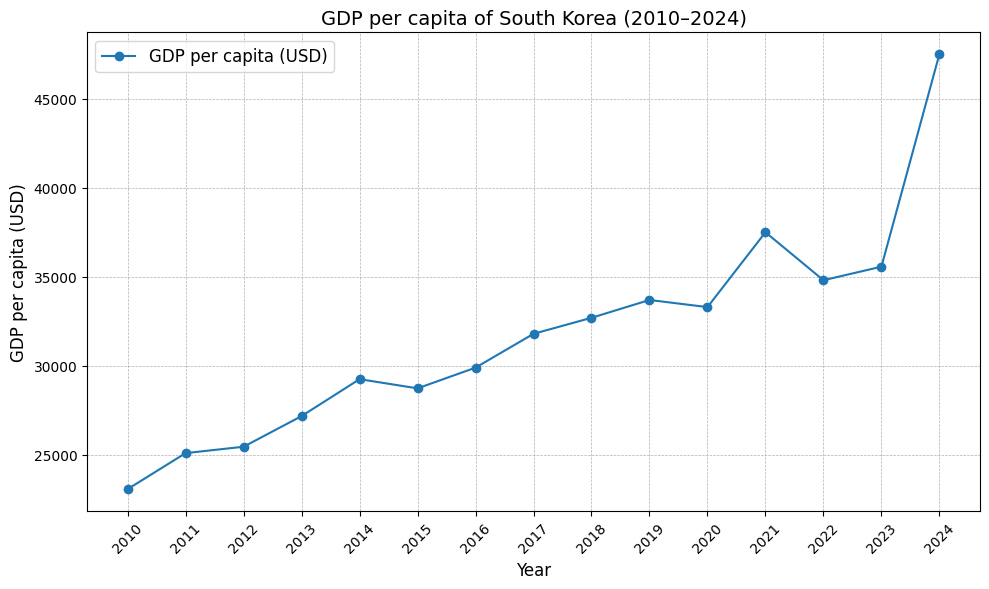


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

I have successfully visualized the GDP per capita of South Korea for the years 2010 to 2024. The graph illustrates the yearly progression and provides a clear view of changes over time. Let me know if you need further modifications or analyses!

🔄 Node: Coder 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: Coder

I have successfully visualized the GDP per capita of South Korea for the years 2010 to 2024. The graph illustrates the yearly progression and provides a clear view of changes over time. Let me know if you need further modifications or analyses!

🔄 Node

In [12]:
import uuid

from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph

# Set config (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(uuid.uuid4())})

# Set input (question)
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the GDP per capita of South Korea from 2010 to 2024."
        )
    ],
}

# Run the graph
invoke_graph(graph, inputs, config)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7rCauVR88WRYWhSdN8436YWY)
 Call ID: call_7rCauVR88WRYWhSdN8436YWY
  Args:
    query: GDP per capita of Mexico from 2010 to 2024
  tavily_search_results_json (call_FLyPtkMBXH5rHcIVWkhjzN3H)
 Call ID: call_FLyPtkMBXH5rHcIVWkhjzN3H
  Args:
    query: GDP per capita of Canada from 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "GDP per capita (current US$) - Mexico - World Bank Data", "url": "https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=MX", "content": "GDP per capita (current US$) - Mexico. World Bank n

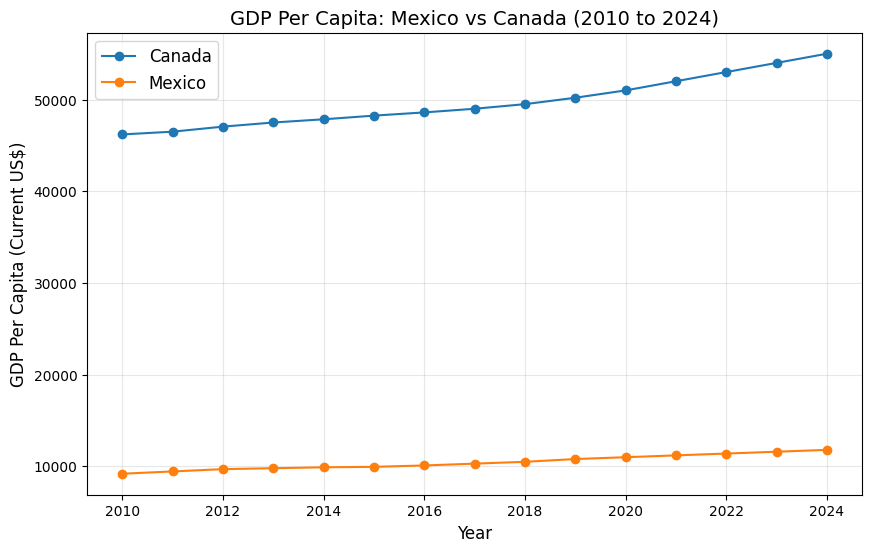


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL

🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_Pb59mlXVnNJTV2tDbbjBw3KO)
 Call ID: call_Pb59mlXVnNJTV2tDbbjBw3KO
  Args:
    query: import pandas as pd
import matplotlib.pyplot as plt

# GDP per capita data for Canada (2010-2024)
data_canada = {'Year': list(range(2010, 2025)),
               'GDP_Per_Capita': [46200, 46500, 47050, 47500, 47850, 48250, 48600, 49000, 49500, 50200, 51000, 52000, 53000, 54000, 55000]}  # Approx. figures}
df_canada = pd.DataFrame(data_canada)

# GDP per capita data for Mexico (2010-2024)
data_mexico = {'Year': list(range(2010, 2025)),
               'GDP_Per_Capita': [9200, 9450, 9700, 9800, 9900, 9950, 10100, 10300, 10500, 10800, 11000, 11

In [13]:
import uuid

from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph

# Set config (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(uuid.uuid4())})

# Set input (question)
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the GDP per capita of Mexico and Canada from 2010 to 2024."
        )
    ],
}

# Run the graph
invoke_graph(graph, inputs, config)